## Model 2: Machine learning algorithm

In [91]:
# import libraries: standard env, +pysal, + jupyter, + matplotlib
#### import libraries ####
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
os.getcwd()

start = timeit.default_timer()

## Read Data

In [92]:
# Read FS data
FS = pd.read_csv('Data/FS_data.csv')


In [93]:
# **Combine processed FS shapefile w/ sars data**

## Model Preprocessing

In [94]:
# Drop unnecessary columns (i.e. space/time no longer need because lags are accounted for)
admin_code = FS['admin_code']
data = FS.drop(['country', 'admin_code', 'admin_name', 'year_month', 'year', 'month', 'geometry'], axis=1)

**Addressing missing values**

 - If 25% of a columns data is NA, that column is removed
 - For all other missing values, the column mean is used - BUT need a better option!

In [95]:
# Establish how much data is missing
print(data.isnull().sum().sort_values(ascending=False).head())

# Find the columns with large amounts of na values
variables_na = []
for i in data:
    if data[i].isnull().sum() > 554:
        str(i)
        variables_na.append(i)
data = data.drop(columns=variables_na) #delete those

timelag2     540
timelag1     270
fews_ipc       0
ndvi_mean      0
rain_mean      0
dtype: int64


In [96]:
# Impute the missing values using SimpleImputer in sklearn.impute
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(data)

data = pd.DataFrame(data=imp.transform(data), columns=data.columns)

# Check if there is still missing data
data.isnull().sum().sort_values(ascending=False).head()

fews_ipc       0
ndvi_mean      0
rain_mean      0
et_mean        0
acled_count    0
dtype: int64

**Normalize the data set**
- Scales each column to values between 0-1 to be better interpreted by the models
- CHECK: how normalisation impacts model accuracy

In [97]:
fews_ipc = data['fews_ipc']
data = data.drop(['fews_ipc'], axis=1)
scaler = MinMaxScaler()
data = gpd.GeoDataFrame(scaler.fit_transform(data), columns=data.columns, index=FS.index)
data.head()
data.describe()
data['class'] = fews_ipc

**Add Binary Classification**
- Using column quartiles as a suitable threshold base
- CHECK: how classification complexity impacts models
- NOTE: Using +3 classes would be more informative in our model explorations

In [98]:
# Binary classification based on quartiles
data['class'] = [0 if x == 1 else 1 for x in data['class']]
data['class'] = data['class'].astype(float) # Reformat column


## Random Forest Classification

In [99]:
#### RANDOM FOREST CLASSIFICATION ####

# A. SPLIT TRAIN/TEST SETS
# Random 70% split in train and test sets (time series is accounted for by lags)
# split data into x & y
y = data['class']
x = data.drop(columns=['class'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [100]:
# Load function for plotting confusion matrix
def plot_confusion_matrix(train_pred, train, dom):
    classes = {'Food Security': 0, 'Food Insecurity': 1}
    cf = confusion_matrix(train_pred,train)
    sns.heatmap(cf,annot=True,yticklabels=classes,xticklabels=classes,cmap='Blues', fmt='g')
    plt.title(f'{dom} Confusion matrix')
    plt.tight_layout()
    plt.figure(figsize=(1, 2), dpi=80)
    plt.show()



In [101]:
# B. OPTIMISE MODEL HYPERPARAMETERS
# Hyperparameter grid search (112)


In [102]:
# C. RESULTS
# Fit optimised model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

RandomForestClassifier()

Ensemble Train Model Accuracy(in %): 100.0
Ensemble Test Model Accuracy(in %): 96.79012345679013


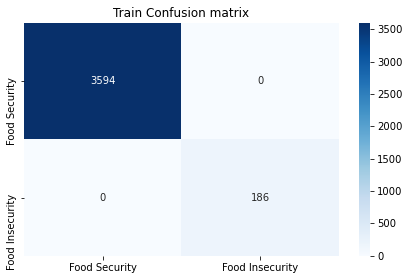

<Figure size 80x160 with 0 Axes>

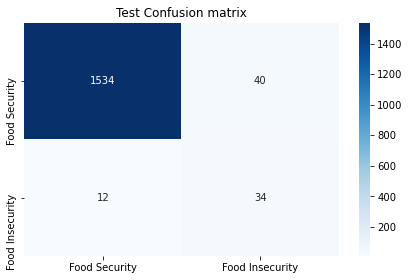

<Figure size 80x160 with 0 Axes>

In [103]:
# Evaluate model
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
print(f'Ensemble Train Model Accuracy(in %): {metrics.accuracy_score(y_train_pred,y_train)*100}')
print(f'Ensemble Test Model Accuracy(in %): {metrics.accuracy_score(y_test_pred,y_test)*100}')
plot_confusion_matrix(y_train_pred,y_train,dom='Train')
plot_confusion_matrix(y_test_pred,y_test,dom='Test')

In [104]:
# Evaluate Variable importance



In [105]:
# Make individual prediction


stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  1.856448200000159
